In [64]:
# Importing the necessary libraries:

import os
import pandas as pd
import matplotlib.pyplot as plt
from langchain_experimental.agents import create_pandas_dataframe_agent
from langchain_core.tools import Tool
from langchain_google_genai import ChatGoogleGenerativeAI

# Install necessary libraries if not already present:
#pip install matplotlib
#pip install -U langchain-google-genai


In [65]:
# Importing the dataset:
df = pd.read_csv("sales-data-analysis.csv") # Ensure the filename matches the CSV file in your local directory.
df.head()


,Order ID,Date,Product,Price,Quantity,Purchase Type,Payment Method,Manager,City
0,10452,07-11-2022,Fries,3.49,573.07,Online,Gift Card,Tom Jackson,London
1,10453,07-11-2022,Beverages,2.95,745.76,Online,Gift Card,Pablo Perez,Madrid
2,10454,07-11-2022,Sides & Other,4.99,200.40,In-store,Gift Card,Joao Silva,Lisbon
3,10455,08-11-2022,Burgers,12.99,569.67,In-store,Credit Card,Walter Muller,Berlin
4,10456,08-11-2022,Chicken Sandwiches,9.95,201.01,In-store,Credit Card,Walter Muller,Berlin


### Dataset Pre-processing:

In [66]:
# Insprecting the dataset to check data types and missing values:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Order ID        254 non-null    int64  
 1   Date            254 non-null    object 
 2   Product         254 non-null    object 
 3   Price           254 non-null    float64
 4   Quantity        254 non-null    float64
 5   Purchase Type   254 non-null    object 
 6   Payment Method  254 non-null    object 
 7   Manager         254 non-null    object 
 8   City            254 non-null    object 
dtypes: float64(2), int64(1), object(6)
memory usage: 18.0+ KB


In [67]:
# Normalizing column names for consistency:
# Standardizing names ensures the LLM agent can reference columns without worrying about case or spaces.
df.columns = ( 
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
)

df.columns # Verifying column names after normalization: 

Index(['order_id', 'date', 'product', 'price', 'quantity', 'purchase_type',
       'payment_method', 'manager', 'city'],
      dtype='object')

In [ ]:
# Cleaning the manager names to ensure data grouping is accurate:
# This step prevents the agent from seeing 'John Doe' and 'John   Doe' as two different managers.

df["manager"] = (
    df["manager"]
    .str.strip()                           # Remove whitespaces
    .str.replace(r"\s+", " ", regex=True)  # Replace multiple spaces with a single space 
)


In [69]:
# Checking current data types to identify columns needing conversion:
df.dtypes

order_id            int64
date               object
product            object
price             float64
quantity          float64
purchase_type      object
payment_method     object
manager            object
city               object
dtype: object

In [70]:
# Converting date column into datetime type for time-based analysis:
df["date"] = pd.to_datetime(df["date"], format="%d-%m-%Y", errors="coerce")

# Ensures that the dataset is always sorted chronoligcally
df = df.sort_values("date").reset_index(drop=True)

In [71]:
df.dtypes # Verifying date column conversion:

order_id                   int64
date              datetime64[ns]
product                   object
price                    float64
quantity                 float64
purchase_type             object
payment_method            object
manager                   object
city                      object
dtype: object

In [72]:
# Adding helper columns from the dataset to help the LLM agent in analysis:

# Calculate total revenue for each transaction:
df["revenue"] = df["price"] * df["quantity"]

# Extract day names and day numbers for day-wise and week-wise performance analysis:
df["day_name"] = df["date"].dt.day_name()
df["weekday_number"] = df["date"].dt.weekday + 1

# Identify weekends for weekend vs weekday performance analysis:
df["is_weekend"] = df["weekday_number"].isin([6, 7])

# Extract month names and month numbers for month-wise performance analysis:
df["month_number"] = df["date"].dt.month
df["month_name"] = df["date"].dt.month_name()


In [73]:
df.head() # Verifying the final dataset:

,order_id,date,product,price,quantity,purchase_type,payment_method,manager,city,revenue,day_name,weekday_number,is_weekend,month_number,month_name
0,10452,2022-11-07,Fries,3.49,573.07,Online,Gift Card,Tom Jackson,London,2000.0143,Monday,1,False,11,November
1,10453,2022-11-07,Beverages,2.95,745.76,Online,Gift Card,Pablo Perez,Madrid,2199.9920,Monday,1,False,11,November
2,10454,2022-11-07,Sides & Other,4.99,200.40,In-store,Gift Card,Joao Silva,Lisbon,999.9960,Monday,1,False,11,November
3,10455,2022-11-08,Burgers,12.99,569.67,In-store,Credit Card,Walter Muller,Berlin,7400.0133,Tuesday,2,False,11,November
4,10456,2022-11-08,Chicken Sandwiches,9.95,201.01,In-store,Credit Card,Walter Muller,Berlin,2000.0495,Tuesday,2,False,11,November


### Sales Forecasting and Inventory Estimation Tool:

In [74]:
# This code projects next week's demand by averaging recent sales and estimates the raw ingredients required to fulfill that 

# Mapping products to their specific ingredients and quantities needed per unit sold. :
# This allows the agent to translate sales demand into raw inventory needs.

RECIPES = {
    "Burgers": {
        "Burger Buns": 1,
        "Beef Patties": 1,
        "Cheese Slices": 2,
        "Lettuce (g)": 20,
        "Tomatoes (g)": 30,
        "Cooking Oil (ml)": 15
    },
    "Fries": {
        "Potatoes (kg)": 0.25,
        "Salt (g)": 5,
        "Cooking Oil (ml)": 50
    },
    "Chicken Sandwiches": {
        "Sandwich Buns": 1,
        "Chicken Breast": 1,
        "Mayo (g)": 15,
        "Lettuce (g)": 20,
        "Cooking Oil (ml)": 15
    },
    "Beverages": {
        "Cups": 1,
        "Straws": 1,
        "Cola Syrup (ml)": 200
    },
    "Sides & Other": {
        "Side Trays": 1,
        "Tomatoes (g)": 25,
        "Salad Mix (g)": 40
    }
}


# Converting raw numeric amounts into user-friendly units (eg. grams to kilograms):
def format_ingredient(item, amount):

    name = item.lower()

    # Convert ml to Liters if volume is large:
    if "ml" in name:
        if amount >= 1000:
            liters = amount / 1000
            return f"{liters:,.2f} L"
        else:
            return f"{round(amount,2):,} ml"

    # Convert grams to kg if weight is large:
    if "(g)" in name or " g" in name:
        if amount >= 1000:
            kg = amount / 1000
            return f"{kg:,.2f} kg"
        else:
            return f"{round(amount,2):,} g"

    # kg stays kg
    if "kg" in name:
        return f"{round(amount,2):,} kg"

    # Discrete items/items without units(ml,kgs) are rounded off as whole numbers:
    return f"{int(round(amount)):,}"

# This function calculates the 7-day forecast and aggregates total ingredient needs:
def estimate_next_week_inventory(df):

    # Determine the most recent 7-day window from the data:
    last_date = df["date"].max()
    last_week = df[df["date"] >= (last_date - pd.Timedelta(days=6))]

    # # Calculate mean daily sales from last week and project for the upcoming week:
    avg_daily_sales = last_week.groupby("product")["quantity"].mean()

    # Forecast next week's sales:
    next_week_sales = (avg_daily_sales * 7).round(2)
    next_week_sales = next_week_sales.sort_values(ascending=False)

    ingredient_totals = {}

    # Convert the forecasted product demand into specific raw ingredients needed:
    for product, qty in next_week_sales.items():
        if product not in RECIPES:
            raise ValueError(f"No recipe defined for {product}")

        for ingredient, amount in RECIPES[product].items():

            # Multiply the predicted quantity by the ingredient amount and add to total:
            total = qty * amount
            ingredient_totals[ingredient] = ingredient_totals.get(ingredient, 0) + total

    # Sorting ingredient list alphabetically:
    ingredient_totals = dict(sorted(ingredient_totals.items()))

    # Formatting the final output:
    output = "Next week forecast based on recent sales trends\n\n"

    output += "Expected product demand:\n"
    for product, qty in next_week_sales.items():
        output += f"{product}: {int(round(qty)):,} units\n"

    output += "\nEstimated ingredient requirements:\n"
    for item, amount in ingredient_totals.items():
        formatted_amount = format_ingredient(item, amount)
        output += f"{item}: {formatted_amount}\n"

    output += "\nBased on average sales trends from the last 7 days."

    return output

# Define the tool for the agent to use when asked about sales/inventory forecasting: 
forecast_tool = Tool(
    name="inventory_forecaster",
    func=lambda _: estimate_next_week_inventory(df),
    description=(
        "Use this tool for questions about next week demand, how much to order, "
        "inventory planning, or ingredient requirements."
    )
)


### Monthly Sales Report Tool for automated visualization:

In [75]:
# This code generates a visual sales report for a specific month, including daily trends, product performance, and weekday averages:

def generate_sales_report_tool(input_text: str):

    # Extract the user's query from the input and convert it to lowercase for reliable matching:
    if isinstance(input_text, dict):
        query = input_text.get("query", "")
    else:
        query = str(input_text)

    query_lower = query.lower()

    # Month detection:
    if "november" in query_lower or "nov" in query_lower:
        month = "November"
    elif "december" in query_lower or "dec" in query_lower:
        month = "December"
    elif "last month" in query_lower:
        month = "November"
    elif "this month" in query_lower:
        month = "December"
    else:
        month = "December" # If user doesn't specify a month, generate report for current month(ie. December)

    # Filter the main dataset for the selected month:
    month_df = df[df["month_name"] == month]

    if month_df.empty:
        return f"No data available for {month}"  # Fallback message in case of data unavailability

    ##  This tool creates 3 data visualizations which provides a brief overview of the overall sales performance for the month:
    
    
    # Group data for chart 1(Daily revenue trend for the month):
    daily_rev = (
        month_df.groupby("date")["revenue"]
        .sum()
        .sort_index()
        .tail(30)
    )

    # Group data for chart 2(Total revenue contributed by each product for the month):
    product_rev = (
        month_df.groupby("product")["revenue"]
        .sum()
        .sort_values(ascending=False)
    )

    # Group data for chart 3(Average revenue generated on each day of the week for the month):
    weekday_rev = (
        month_df.groupby(["weekday_number","day_name"])["revenue"]
        .mean()
        .reset_index()
        .sort_values("weekday_number")
    )


    # Plotting the charts using Matplotlib:

    plt.style.use("ggplot")
    fig, axes = plt.subplots(3, 1, figsize=(8, 10)) # Initialize a 3-row subplot for the 3 charts:

    # Plot 1 : Daily revenue trend for the month:
    axes[0].plot(daily_rev.index, daily_rev.values, marker="o")
    axes[0].set_title(f"Daily Revenue Trend($) ({month})")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Revenue ($)")
    axes[0].grid(True)
    axes[0].set_xticks(daily_rev.index)
    axes[0].set_xticklabels(daily_rev.index.day)

    # Plot 2: Total revenue contributed by each product for the month:
    axes[1].bar(product_rev.index, product_rev.values, color="#4C72B0")
    axes[1].set_title(f"Revenue by Product($) ({month})")
    axes[1].tick_params(axis="x", rotation=30)

    # Plot 3: Average revenue generated on each day of the week for the month: 
    axes[2].bar(weekday_rev["day_name"], weekday_rev["revenue"], color="#55A868")
    axes[2].set_title(f"Average Revenue by Day ($) ({month})")

    # Save and display the final visual report:
    plt.tight_layout()
    plt.savefig("sales_report.png")   # save the chart as an image file
    plt.show()                        # display in notebook

    return (
        f"Sales report for {month} generated and saved as sales_report.png. "
        f"The chart has been displayed and also saved as sales_report.png."
    )



# Define the visualization tool for the agent:
sales_report_tool = Tool(
    name="generate_sales_report",
    func=generate_sales_report_tool,
    description="Use this tool when the user asks for charts, graphs, or visual sales reports."
)

### System Prompt:

In [76]:
# This system prompt defines the agent's persona as a restaurant analyst. It also includes rules for data handling, time interpretation, and tool usage:

system_prompt = """
You are a restaurant business analyst working with a pandas dataframe named df.


You analyze structured sales data using Python and pandas tools to help a branch manager understand performance, trends, and ordering needs and sales analysis.
IMPORTANT RULES:
- The dataframe is already loaded and named df.
- NEVER recreate the dataframe.
- NEVER generate fake tables or sample data.
- ALWAYS use the existing dataframe df for all calculations.

-----------------------------------
GOAL
-----------------------------------
Provide accurate, data-backed business insights that help a restaurant manager make decisions.

-----------------------------------
TIME INTERPRETATION RULES:

- The dataset contains historical dates.
- Always treat the latest date in df as "today".

Definitions:
- "Last week" = the 7 days ending at the latest date in df.
- "This week" = same as last week if data is historical.
- "Last month" = previous calendar month in df.
- If user asks "last week" or "recent week":
  → filter df where date >= max(df.date) - 6 days

Never ask the user to define the time range if it can be inferred from df.
Always compute it yourself.


TOOL CALLING: 
-----------------------------------
Inventory::
- If user asks how much to order or ingredient needs,
  assume they want ALL items unless specified.
- Always use inventory_forecaster for such questions.
- Do not ask clarification questions.
  
For time-based queries:
- Use the latest date in df as the reference point.

Visualization:
If the user asks for charts, graphs, trends, or a sales report,
use the generate_sales_report tool.

-----------------------------------
TOP-SELLING QUESTIONS:

If user asks for top/best/highest selling items:

1. Always compute from df.
2. Default ranking = revenue.
3. If user says "by quantity" → use quantity.
4. If time mentioned (last week/month):
   → apply time filter first
   → then rank.
5. Never say you lack functionality.
6. Never ask for clarification if time can be inferred.


-----------------------------------
COMPARISON QUESTIONS
-----------------------------------
When comparing periods (months, weeks, days):
- Always compute the difference.
- Include percentage change if meaningful.
- Provide a one-sentence insight.

Example style:
"November revenue was $29,400, which is $1,600 higher than October ($27,800), a 5.7% increase."

-----------------------------------


-----------------------------------
"WHY" QUESTIONS (DATA-FIRST ANALYSIS)
-----------------------------------
When asked why sales changed/dropped/spiked:

1. Identify the period being discussed.
2. Compare it to a relevant baseline (other days, weeks, or months).
3. Check for patterns in:
   - day_name
   - is_weekend
   - product-level revenue
   - quantity trends
4. Describe correlations using numbers.
5. Provide a short analyst-style explanation.

Rules:
For "why" analysis:
- Perform calculations once
- Base reasoning only on the dataset.
- Use a single clear comparison
- Then produce final answer
- If no clear pattern exists, say so.
- Do not re-run analysis


Example:
"Thursday revenue is $26,600, about 38% lower than the weekend average of $42,600, indicating stronger weekend demand."


DAY QUESTIONS:

If the user asks a question about a day of the week (e.g., "Why did sales drop on Saturday?"):

- If the user specifies an exact date → analyze that specific date.
- If the user does NOT specify a date → interpret it as the overall performance of that weekday across the dataset.
- Compare that weekday’s average/total revenue with other days of the week.
- Identify patterns using:
  - day_name
  - is_weekend
  - revenue and quantity trends
  - product mix
- Provide a concise explanation.


-----------------------------------
OUTPUT FORMATTING RULES
-----------------------------------
- Be concise and business-friendly.
- Use commas for large numbers (e.g., 27,800).
- For revenue, include a $ sign and round to 2 decimals.
- Do not use markdown symbols (*, **, bullet points).
- Return tool outputs exactly as provided when using tools.

"""



### Setting up the Gemini LLM:

In [ ]:
os.environ["GOOGLE_API_KEY"] = "Paste your Google API key here" 


In [78]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,  # Set to 0 for grounded, factual, and data-driven answers
    streaming=False # Delivers the full answer at once
)


In [79]:
agent = create_pandas_dataframe_agent(
    llm,
    df,
    verbose=False,             # Hides the internal reasoning steps to keep output clean
    prefix=system_prompt,      # Injects prompt into the agent to guide it's behavior and responses
    allow_dangerous_code=True, # Required to let the agent execute pandas operations on its own
    agent_type="tool-calling", # Enables the agent to call external tools when needed
    extra_tools=[forecast_tool, sales_report_tool], # Adds custom toolds 
    max_iterations=5,          # Limits agent to 5 steps to prevent infinite loops
)


In [91]:
# Print clean responses:
def ask_analyst(query):
    result = agent.invoke(query)
    print(f"Query: {query}")
    print(f"Response: {result['output']}")

### Final Testing: 

In [90]:
ask_analyst("What were the top selling items last week?")

Query: What were the top selling items last week?
Response: Last week's top-selling items by revenue were: Burgers ($63,199.86), Chicken Sandwiches ($18,800.23), Fries ($15,400.00), Beverages ($14,000.08), and Sides & Other ($6,000.00).



In [ ]:
ask_analyst("How much ingredients should we order for next week?") # Using forecasting tool: 

Query: How much ingredients should we order for next week?
Response: Here are the ingredient requirements for next week:

Beef Patties: 4,865
Burger Buns: 4,865
Cheese Slices: 9,731
Chicken Breast: 1,889
Cola Syrup (ml): 949.16 L
Cooking Oil (ml): 321.95 L
Cups: 4,746
Lettuce (g): 135.09 kg
Mayo (g): 28.34 kg
Potatoes (kg): 1,103.15 kg
Salad Mix (g): 56.11 kg
Salt (g): 22.06 kg
Sandwich Buns: 1,889
Side Trays: 1,403
Straws: 4,746
Tomatoes (g): 181.03 kg


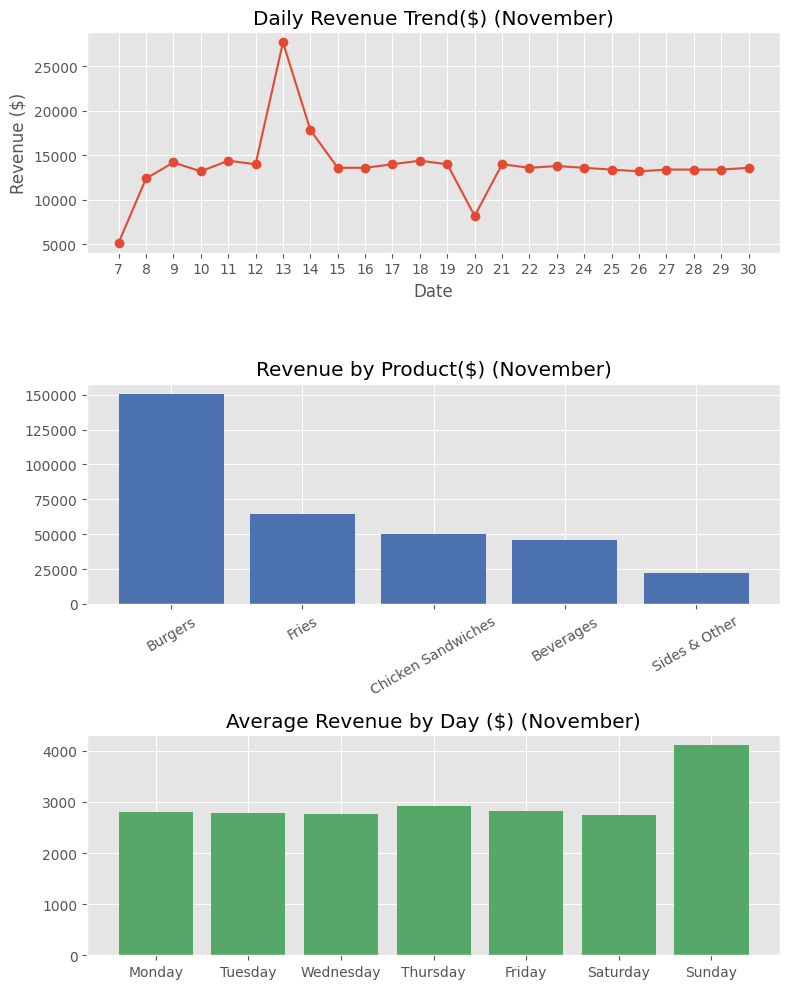

Query: Can you give me a sales report for November?
Response: Here is your sales report for November. The chart has been displayed and also saved as sales_report.png.



In [ ]:
ask_analyst("Can you give me a sales report for November?") # Using sales report tool

In [94]:
ask_analyst("Why were Saturday sales lower than the rest of the week?")

Query: Why were Saturday sales lower than the rest of the week?
Response: Saturday revenue averages $2,902.87, which is lower than the Sunday average of $3,637.06, indicating weaker weekend demand on Saturdays compared to Sundays.


In [ ]:
ask_analyst("Compare revenue for November and December")

Query: Compare revenue for November and December
Response: November revenue was $63,600.05, which is $7,200.03 lower than December ($70,800.08), a 11.32% decrease.


In [103]:
ask_analyst("Which day of the week is usually our busiest, and what products drive that traffic?")

Query: Which day of the week is usually our busiest, and what products drive that traffic?
Response: Wednesday is the busiest day, with total revenue of $117,800. Burgers are the top-selling product on Wednesdays, accounting for $58,600 of the revenue.


In [106]:
ask_analyst("How many burger buns and sandwiches should I order for next week?")

Query: How many burger buns and sandwiches should I order for next week?
Response: Here's what you should order for next week: 4,865 burger buns and 1,889 sandwich buns.

